<img src="./SGLD_algo.png" width="800" height="800"/>

SGLD optimizer updates parameters like this:
$$\Delta w_t = \frac{\epsilon}{2}\left(\frac{\beta n}{m} \sum_{i=1}^m \nabla \log p\left(y_{l_i} \mid x_{l_i}, w_t\right)+\gamma\left(w_0-w_t\right) - \lambda w_t\right) + N(0, \epsilon\sigma^2)$$

In [105]:
from devinterp.optim.sgld import SGLD
from devinterp.slt.callback import SamplerCallback
from typing import Callable, Dict, List, Literal, Optional, Type, Union
from devinterp.utils import (
    USE_TPU_BACKEND,
    EvaluateFn,
    EvalResults,
    default_nbeta,
    get_init_loss_multi_batch,
)
if USE_TPU_BACKEND:
    from devinterp.backends.tpu.slt.sampler import sample
else:
    from devinterp.backends.default.slt.sampler import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import copy

DEVICE = "cuda"

In [106]:
class BIFEstimator(SamplerCallback):
    def __init__(
        self,
        num_chains: int,
        num_draws: int,

        num_data: int,
        num_obs: int,
        
        init_loss: torch.Tensor,
        device: Union[torch.device, str] = "cpu",
        eval_field: List[str] = ["loss", "obs"],
        nbeta: float = None,
        temperature: float = None,
    ):
        self.num_chains = num_chains
        self.num_draws = num_draws
        self.num_data = num_data
        self.num_obs = num_obs
        
        self.losses = torch.zeros((num_data, num_chains*num_draws), dtype=torch.float32).to(
            device
        )
        self.observables = torch.zeros((num_obs, num_chains*num_draws), dtype=torch.float32).to(
            device
        )
        self.init_loss = init_loss

        assert nbeta is not None or temperature is not None, (
            "Please provide a value for nbeta."
        )
        if nbeta is None and temperature is not None:
            nbeta = temperature
            warnings.warn("Temperature is deprecated. Please use nbeta instead.")
            
        self.nbeta = torch.tensor(nbeta, dtype=torch.float32).to(device)
        self.temperature = temperature

        self.device = device
        self.eval_field = eval_field

    def update(self, chain: int, draw: int, loss_vec: torch.tensor, obs_vec: torch.tensor):
        if torch.isnan(loss_vec).any():
            raise RuntimeError(f"NaN detected in loss at chain {chain}, draw {draw}")

        col = chain * self.num_draws + draw
        self.losses[:, col] = loss_vec.to(self.device)
        self.observables[:, col] = obs_vec.to(self.device)


    def get_results(self):
        """
        :returns: A dict :python:`
        {"llc/mean": llc_mean, "llc/std": llc_std, "llc-chain/{i}": llc_trace_per_chain, "loss/trace": loss_trace_per_chain}`. 
        (Only after running :python:`devinterp.slt.sampler.sample(..., [llc_estimator_instance], ...)`).
        """

        init_loss = (
            self.init_loss.item()
            if isinstance(self.init_loss, torch.Tensor)
            else self.init_loss
        )


        # calculating BIF matrix where BIF_ij = BIF(z_i, phi_j)
        # returns matrix of (num_data x num_obs)
        CT = self.num_chains * self.num_draws
        multiplier_mat = (torch.eye(CT) - torch.full((CT,CT), 1/CT)).to(self.device)
        multiplier_mat = torch.matmul(multiplier_mat, multiplier_mat.T)
        BIF = 1/(CT - 1) * torch.matmul(torch.matmul(self.losses, multiplier_mat), self.observables.T)

        return {
            "init_loss": init_loss,
            "BIF": BIF,
            "loss/trace": self.losses.cpu().numpy(),
            "obs/trace": self.observables.cpu().numpy(),
        }

    def finalize(self):
        if os.environ.get("USE_SPMD", "0") == "1" and not str(self.device).startswith(
            "cpu:"
        ):
            if str(self.device).startswith("cuda") and torch.cuda.device_count() > 1:
                if torch.distributed.is_initialized():
                    torch.distributed.barrier()
                    torch.distributed.all_reduce(
                        self.losses, op=torch.distributed.ReduceOp.AVG
                    )
            else:
                pass

        elif USE_TPU_BACKEND and str(self.device).startswith("xla:"):
            import torch_xla.core.xla_model as xm

            if TPU_TYPE == "v4":
                self.losses = xm.all_reduce(xm.REDUCE_SUM, self.losses)
            elif TPU_TYPE == "v2/v3":
                self.losses = self.losses.cpu()
                if torch.distributed.is_initialized():
                    torch.distributed.all_reduce(self.losses)
                else:
                    warnings.warn(
                        "torch.distributed has not been initialized. If running on TPU v2/v3, and you want to run chains in parallel, you need to initialize torch.distributed after calling xmp.spawn() as follows:"
                        ">>> import torch_xla.runtime as xr"
                        ">>> store = torch.distributed.TCPStore('127.0.0.1', 12345, 4, xr.global_ordinal() == 0)"
                        ">>> torch.distributed.init_process_group(backend='gloo', store=store, rank=xr.global_ordinal()//2, world_size=xr.world_size()//2)"
                    )

            else:
                raise NotImplementedError(f"TPU type {TPU_TYPE} not supported")
        elif str(
            self.device
        ).startswith(
            "cuda"
        ):  # if we've ran on multi-GPU, we should do a reduce as well. see above for how this would work
            try:
                torch.distributed.all_reduce(self.losses)
            except ValueError:
                pass

    def __call__(self, chain: int, draw: int, **kwargs):
        self.update(chain, draw, kwargs["results"]["loss_vec"], kwargs["results"]["obs"])
        

In [107]:
def estimate_bif(
    model: torch.nn.Module,
    loader: DataLoader,
    num_obs: int,
    callbacks: List[Callable] = [],
    evaluate: Optional[EvaluateFn] = None,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    sampling_method_kwargs: Optional[
        Dict[str, Union[float, Literal["adaptive"]]]
    ] = None,
    num_draws: int = 100,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    init_loss: float = None,
    gradient_accumulation_steps: int = 1,
    cores: Union[int, List[Union[str, torch.device]]] = 1,
    seed: Optional[Union[int, List[int]]] = None,
    device: Union[torch.device, str] = torch.device("cuda"),
    gpu_idxs: Optional[List[int]] = None,
    verbose: bool = True,
    optimize_over_per_model_param: Optional[Dict[str, torch.Tensor]] = None,
    online: bool = False,
    dtype: Optional[torch.dtype] = None,
    num_data: int = -1
) -> dict:

    # Using hyperparameters from kreer BIF paper, see "vision" in table in paper
    sampling_method_kwargs = dict()
    sampling_method_kwargs["nbeta"] = 10
    sampling_method_kwargs["localization"] = 1000
    sampling_method_kwargs["lr"] = 1e-4

    if not init_loss:
        init_loss = get_init_loss_multi_batch(
            loader, num_chains * gradient_accumulation_steps, model, evaluate, device
        )

    if num_data == -1:
        num_data = len(loader)
    
    bif_estimator = BIFEstimator(
            num_chains,
            num_draws,
            nbeta=sampling_method_kwargs["nbeta"],
            device=device,
            init_loss=init_loss,
            num_obs=num_obs, 
            num_data = num_data
        )
    
    callbacks = [bif_estimator, *callbacks]

    sample(
        model=model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        sampling_method_kwargs=sampling_method_kwargs,
        num_draws=num_draws,
        num_chains=num_chains,
        num_burnin_steps=num_burnin_steps,
        num_steps_bw_draws=num_steps_bw_draws,
        gradient_accumulation_steps=gradient_accumulation_steps,
        cores=cores,
        seed=seed,
        device=device,
        verbose=verbose,
        callbacks=callbacks,
        optimize_over_per_model_param=optimize_over_per_model_param,
        gpu_idxs=gpu_idxs,
        dtype=dtype,
        init_loss=init_loss,
    )

    results = {}

    for callback in callbacks:
        if hasattr(callback, "get_results"):
            results.update(callback.get_results())

    return results

In [108]:
class NeuralNet(nn.Module):
    def __init__(self, non_linear_activation=nn.ReLU(), input_dim=2, output_dim=2):
        super().__init__()
        self.non_linear_activation = non_linear_activation

        self.f = nn.Sequential(
            nn.Linear(input_dim, 10),
            self.non_linear_activation,
            nn.Linear(10, output_dim)
        )

    def forward(self, x):
        return self.f(x)

In [109]:
def gen_synthetic_data(N=50):
    xs=ys=-2
    xe=ye=2
    
    X1 = np.linspace(xs,xe,N)
    X2 = np.linspace(ys,ye,N)
    
    X = np.meshgrid(X1,X2)
    X = np.stack([x.ravel()[:None] for x in X], axis=-1)
    
    Y = ((np.square(X[:,0]) + np.square(X[:,1])) <= 1).astype("int")

    return torch.from_numpy(X).float(), torch.from_numpy(Y)

In [110]:
def train(N=40):
    data,labels=gen_synthetic_data(N=N)
    data = data.to(DEVICE)
    labels = labels.to(DEVICE)

    net = NeuralNet().to(DEVICE)
    # loss_fn = nn.NLLLoss()
    loss_fn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(net.parameters())

    EPOCHS = 30
    BATCH = 50

    ls = []

    for epoch in range(EPOCHS):
        eloss = 0
        for b in range(100):
            indexes = torch.randperm(data.shape[0])[:BATCH]
            batch = data[indexes]
            target = labels[indexes]
            
            out = net(batch)
            loss = loss_fn(out, target)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            eloss += loss.item()

        tloss = eloss / data.shape[0]
        ls.append(tloss)

    return data,labels,net,ls

In [111]:
data,labels,net,ls = train(N=35)

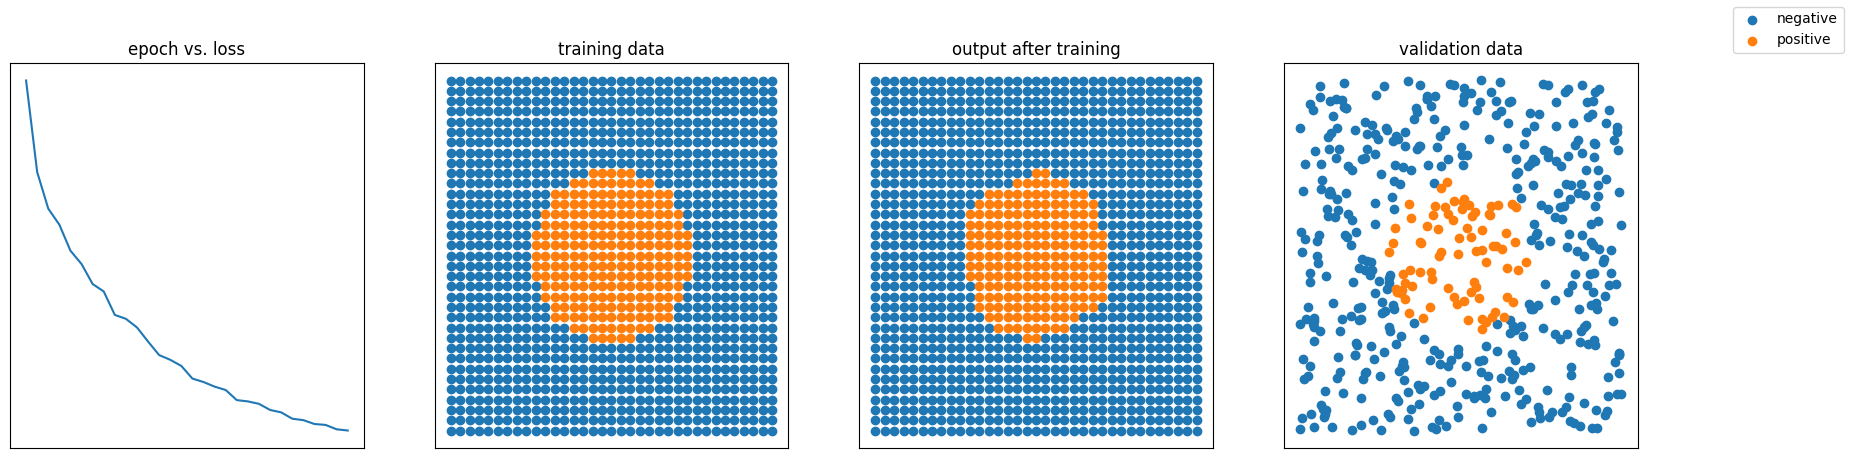

In [112]:
output=None
with torch.no_grad():
    output = torch.argmax(net(data), dim=-1).cpu().numpy()
X = data.cpu().numpy()

valid_data = ((torch.rand((500,2)) - 0.5) * 4).to(DEVICE)
output_valid=None
with torch.no_grad():
    output_valid = torch.argmax(net(valid_data), dim=-1).cpu().numpy()

fig,arr = plt.subplots(1,4,figsize=(21,5))

for a in arr:
    a.set_xticks([])
    a.set_yticks([])

arr[0].plot(np.arange(len(ls)),ls)
arr[0].set_title("epoch vs. loss")

for i in range(2):
    ind_i = labels.cpu() == i
    arr[1].scatter(X[ind_i,0], X[ind_i,1], label="positive" if i > 0 else "negative")
    arr[1].set_title("training data")

fig.legend()

for i in range(2):
    ind_i = output == i
    arr[2].scatter(X[ind_i,0], X[ind_i,1], label=i)
    arr[2].set_title("output after training")

for i in range(2):
    ind_i = output_valid == i
    arr[3].scatter(valid_data[ind_i,0].cpu(), valid_data[ind_i,1].cpu(), label=i)
    arr[3].set_title("validation data")

plt.show()

In [117]:
TESTX = (1.5,1.5)
def get_test_pt(point, device="cpu"):
    x1,x2=point
    norm = np.square(x1) + np.square(x2)
    lab = 1 if norm <= 1 else 0
    return (torch.tensor([x1,x2]).float().to(device), torch.tensor(lab).to(device))

def evaluate_function(model: nn.Module, data: torch.Tensor, device="cpu") -> EvalResults:
    inputs, outputs = data
    x,y = get_test_pt(TESTX, device=device)

    return {
        "loss": torch.nn.functional.cross_entropy(model(inputs), outputs),
        "obs": torch.tensor(torch.nn.functional.cross_entropy(model(x), y).item()),
        "loss_vec": torch.nn.functional.cross_entropy(model(inputs), outputs, reduction="none")
    }

loader = torch.utils.data.DataLoader(list(zip(data,labels)), shuffle=False, batch_size=data.shape[0])

In [118]:
test = estimate_bif(
    model=copy.deepcopy(net),
    loader = loader,
    evaluate = evaluate_function,
    num_obs=1,
    device="cpu",
    num_chains=4,
    num_draws=200,
    num_data=data.shape[0],
)

Chain 3: 100%|███████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 465.04it/s]


In [119]:
BIF = -test["BIF"]
# print(test["obs/trace"])

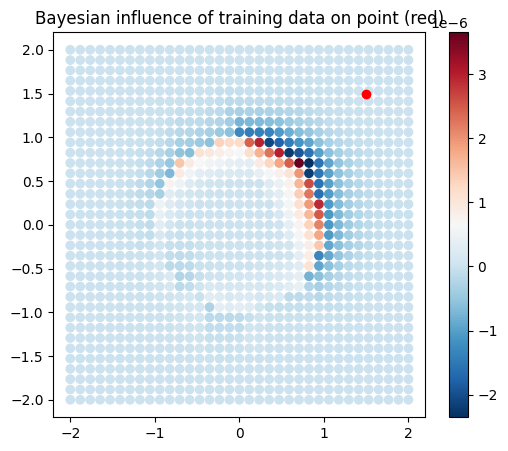

In [120]:
X = data.cpu().numpy()
fig, arr = plt.subplots(1,1,figsize=(6,5))
scatter = arr.scatter(X[:,0], X[:,1], c=BIF[:,0], cmap=cm.RdBu_r)
arr.scatter(TESTX[0], TESTX[1], c="red")
fig.colorbar(scatter, )
plt.title("Bayesian influence of training data on point (red)")
plt.show()